In [ ]:
from google.colab import drive
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow.keras as tfk 
import tensorflow.keras.layers as tfkl 
plt.rc('font', size=16) 
import random
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn import preprocessing 


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [ ]:
# Random seed for reproducibility
seed = 89
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
drive.mount('/gdrive')
os.chdir(r'/gdrive/MyDrive/annHomework2/')
x_train = np.load(r'x_train.npy')
y_train = np.load(r'y_train.npy')

Mounted at /gdrive


In [ ]:
x_train.shape, y_train.shape 

((2429, 36, 6), (2429,))

Is it already divided into windows? I would say yes. 

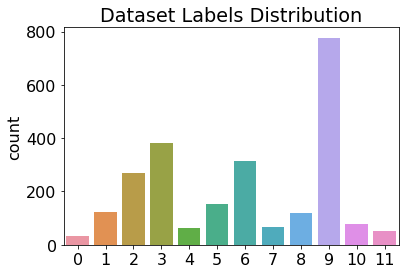

In [ ]:
# plot labels distribution 
sns.countplot( x = y_train) 
plt.title('Dataset Labels Distribution')
plt.show()

As we can see dataset is pretty unbalanced. But, looking at early subs, more prominent classes do not seem to be the best predicted. Why? 

In [ ]:
labels = np.unique(np.fromiter([i for i in y_train], np.int32) )
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=labels, y=y_train) 
y_train = tfk.utils.to_categorical(y_train) 

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=seed, stratify=y_train) 

In [ ]:
train_data = np.concatenate([x for x in x_train]) 
scaler = preprocessing.StandardScaler().fit(train_data)

x_train_trans = [] 
for el in x_train: 
  x_train_trans.append(scaler.transform(el))
del x_train 

x_test_trans = [] 
for el in x_test :
  x_test_trans.append(scaler.transform(el))

x_train = np.asarray(x_train_trans) 
x_test = np.asarray(x_test_trans)
x_train

In [ ]:
# check 
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape) 
x_train[0][1]
y_train[0]

(1943, 36, 6) (1943, 12) (486, 36, 6) (486, 12)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

# **LSTM VANILLA**

In [ ]:
input_shape = (36,6)

In [ ]:
def build_LSTM_classifier(input_shape, classes=12):
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    lstm = tfkl.LSTM(256, return_sequences=True, kernel_initializer="he_uniform")(input_layer) 
    dropout = tfkl.Dropout(.2, seed=seed )(lstm)
    lstm = tfkl.LSTM(256, return_sequences=True, kernel_initializer="he_uniform")(dropout)
    dropout = tfkl.Dropout(.2, seed=seed )(lstm)
    lstm = tfkl.LSTM(256, return_sequences=True, kernel_initializer="he_uniform")(dropout)
    dropout = tfkl.Dropout(.2, seed=seed )(lstm)
    lstm = tfkl.LSTM(256, return_sequences=True, kernel_initializer="he_uniform")(dropout)  
    dropout = tfkl.Dropout(.2, seed=seed )(lstm)
    lstm = tfkl.LSTM(256, return_sequences=True, kernel_initializer="he_uniform")(dropout)  
    dropout = tfkl.Dropout(.2, seed=seed )(lstm)
    lstm = tfkl.LSTM(256)(dropout)
    dropout = tfkl.Dropout(.2, seed=seed )(lstm)
    
    classifier = tfk.Sequential([ 
        tfkl.Input(shape=(256,)), 
        tfkl.experimental.RandomFourierFeatures(output_dim=1024, trainable=True, kernel_initializer="gaussian"),
        tfkl.Dense(units=128,  activation='relu', 
                   kernel_initializer=tfk.initializers.HeUniform(seed),
                   name='dense_classifier1',
                   kernel_regularizer = tfk.regularizers.L1L2(
                       l2 = 0.01
                       )                   
                  ),
        tfkl.Dense(units=128,  activation='relu', 
                   kernel_initializer=tfk.initializers.HeUniform(seed),
                   name='dense_classifier2',
                   kernel_regularizer = tfk.regularizers.L1L2(
                       l2 = 0.01
                       )                   
                  )
    ]) (lstm)

    output_layer = tfkl.Dense(classes, activation='softmax', 
                              kernel_regularizer = tfk.regularizers.L2(l2 = 0.01),
                              kernel_initializer=tfk.initializers.GlorotUniform(seed))(classifier)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate = 1e-3), metrics='accuracy')
    return model

In [ ]:
model = build_LSTM_classifier(input_shape = input_shape, classes=12)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 36, 256)           269312    
                                                                 
 dropout (Dropout)           (None, 36, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 36, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (None, 36, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 36, 256)           525312    
                                                                 
 dropout_2 (Dropout)         (None, 36, 256)           0     

In [ ]:

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 64,
    epochs = 100,
    validation_data = (x_test, y_test) ,      
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/100
31/31 [==============================] - 16s 99ms/step - loss: 6.4285 - accuracy: 0.3464 - val_loss: 5.3278 - val_accuracy: 0.4218 - lr: 0.0010
Epoch 2/100
31/31 [==============================] - 1s 29ms/step - loss: 4.8053 - accuracy: 0.4122 - val_loss: 4.4053 - val_accuracy: 0.4074 - lr: 0.0010
Epoch 3/100
31/31 [==============================] - 1s 27ms/step - loss: 3.9929 - accuracy: 0.4251 - val_loss: 3.6763 - val_accuracy: 0.4588 - lr: 0.0010
Epoch 4/100
31/31 [==============================] - 1s 28ms/step - loss: 3.3867 - accuracy: 0.4735 - val_loss: 3.2236 - val_accuracy: 0.4753 - lr: 0.0010
Epoch 5/100
31/31 [==============================] - 1s 28ms/step - loss: 2.9202 - accuracy: 0.5183 - val_loss: 2.9086 - val_accuracy: 0.4979 - lr: 0.0010
Epoch 6/100
31/31 [==============================] - 1s 27ms/step - loss: 2.6218 - accuracy: 0.5147 - val_loss: 2.6798 - val_accuracy: 0.4918 - lr: 0.0010
Epoch 7/100
31/31 [==============================] - 1s 27ms/step - l

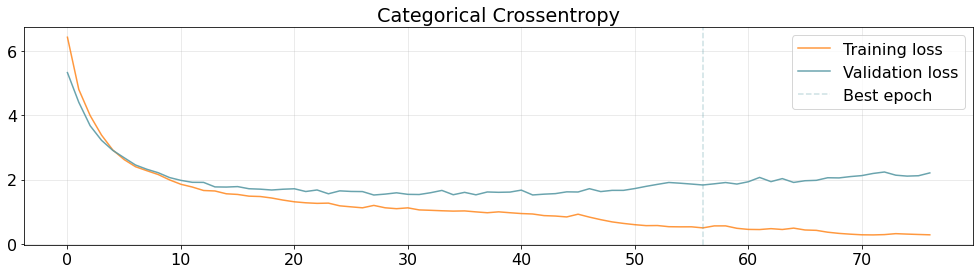

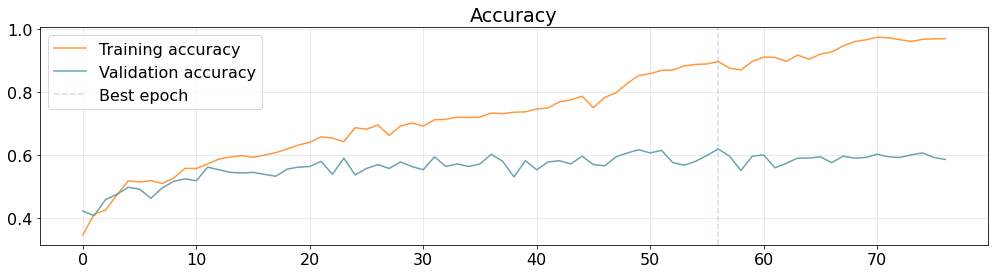

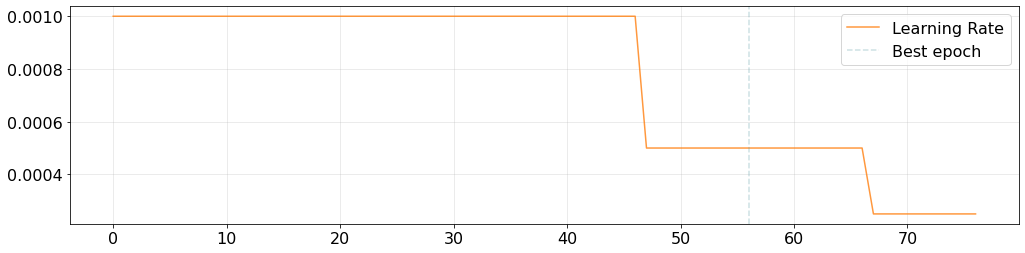

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

16/16 [==============================] - 2s 2ms/step - loss: 0.1766 - accuracy: 0.0000e+00
{'loss': 0.17664000391960144, 'accuracy': 0.0}
16/16 [==============================] - 2s 12ms/step
Accuracy: 0.6193
Precision: 0.664
Recall: 0.4739
F1: 0.5119
F1 (per class): [0.44444444 0.6        0.86792453 0.41290323 0.15384615 0.2962963
 0.71666667 0.09090909 0.8        0.69859155 0.8        0.26086957]


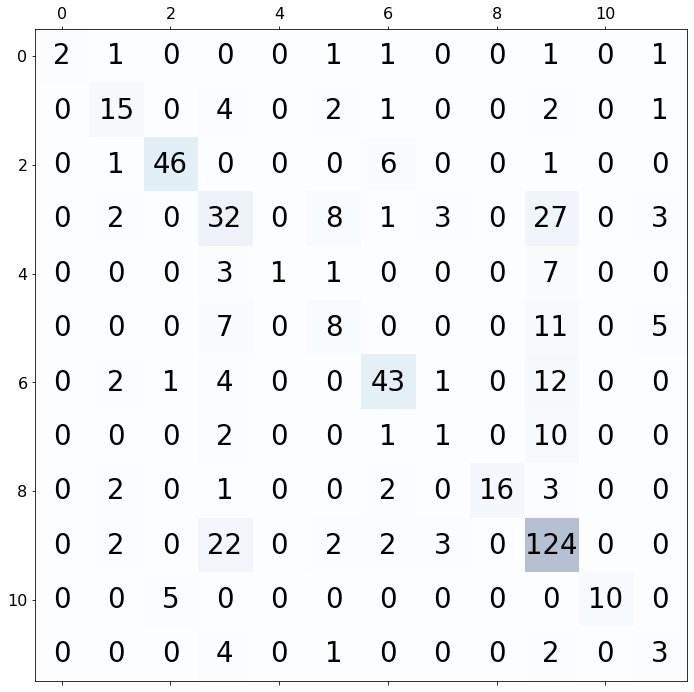

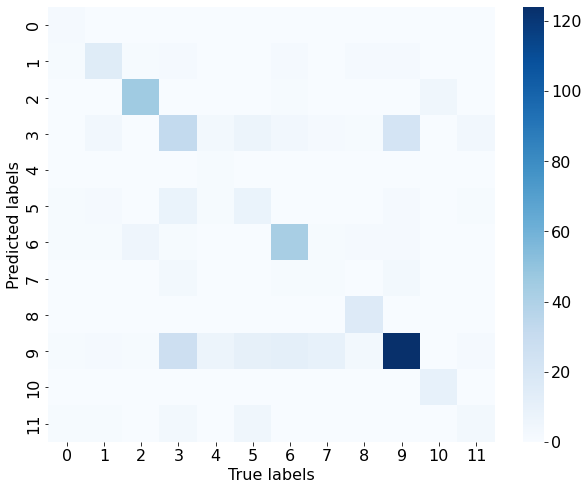

In [ ]:
metrics = model.evaluate(x_test, return_dict=True)
print(metrics)

labels = y_test 
predictions = model.predict(x_test) 
assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):' ,f1_classes)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(12,12))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# 1D Convolutional Neural Network

In [ ]:
def build_1DCNN_classifier(input_shape, classes):
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(input_layer) #
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn) #
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn) #
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn) #
    cnn = tfkl.MaxPooling1D()(cnn)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(cnn) 
    gap = tf.keras.layers.GlobalAveragePooling1D()(bilstm)
    classifier = tfk.Sequential([ 
        tfkl.Input(shape=(256,)), 
        tfkl.experimental.RandomFourierFeatures(output_dim=1024, scale=8.0, kernel_initializer="gaussian"),
        tfkl.Dense(units=128,  activation='relu', 
                   kernel_initializer=tfk.initializers.HeUniform(seed),
                   name='dense_classifier1',
                   kernel_regularizer = tfk.regularizers.L2( l2 = 0.001)                 
                  ),
        tfkl.Dense(units=128,  activation='relu', 
                   kernel_initializer=tfk.initializers.HeUniform(seed),
                   name='dense_classifier2',
                   kernel_regularizer = tfk.regularizers.L2(l2 = 0.001)                   
                  )
    ]) (gap)  
    output_layer = tfkl.Dense(classes, activation='softmax', 
                              kernel_initializer=tfk.initializers.GlorotUniform(seed))(classifier)
      
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model

In [ ]:
model = build_1DCNN_classifier(input_shape, 12)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 36, 256)           4864      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 18, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 18, 256)           196864    
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 9, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 9, 256)            196864

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (x_test, y_test),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=15, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 4s 39ms/step - loss: 2.5018 - accuracy: 0.3335 - val_loss: 2.3221 - val_accuracy: 0.3663 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 0s 12ms/step - loss: 2.1959 - accuracy: 0.3860 - val_loss: 2.0784 - val_accuracy: 0.4115 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 0s 11ms/step - loss: 2.0100 - accuracy: 0.4246 - val_loss: 1.9629 - val_accuracy: 0.4136 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 0s 11ms/step - loss: 1.8377 - accuracy: 0.4508 - val_loss: 1.7966 - val_accuracy: 0.4815 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 0s 11ms/step - loss: 1.7376 - accuracy: 0.4792 - val_loss: 1.7157 - val_accuracy: 0.5103 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 0s 10ms/step - loss: 1.5836 - accuracy: 0.5250 - val_loss: 1.7985 - val_accuracy: 0.4918 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 0s 11ms/step - lo

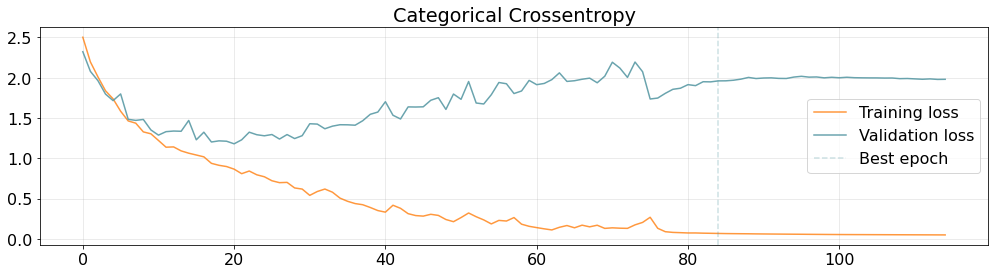

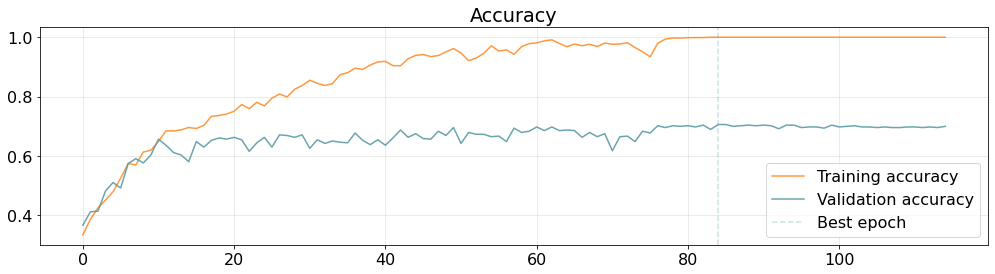

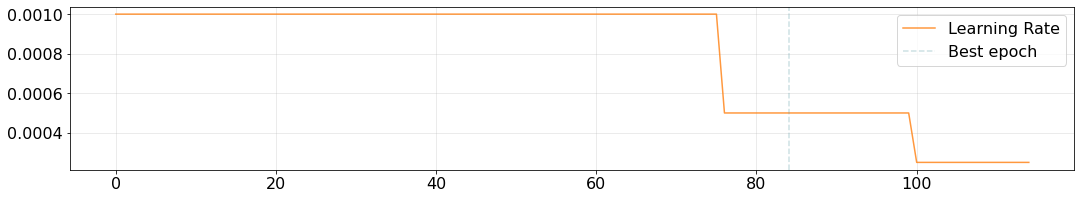

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
predictions = model.predict(x_test)
predictions.shape

16/16 [==============================] - 1s 4ms/step


(486, 12)

Accuracy: 0.7058
Precision: 0.5768
Recall: 0.5599
F1: 0.5645
F1 (per class): [0.         0.71698113 0.90384615 0.54929577 0.2        0.37037037
 0.90769231 0.0952381  0.91304348 0.76047904 0.85714286 0.5       ]


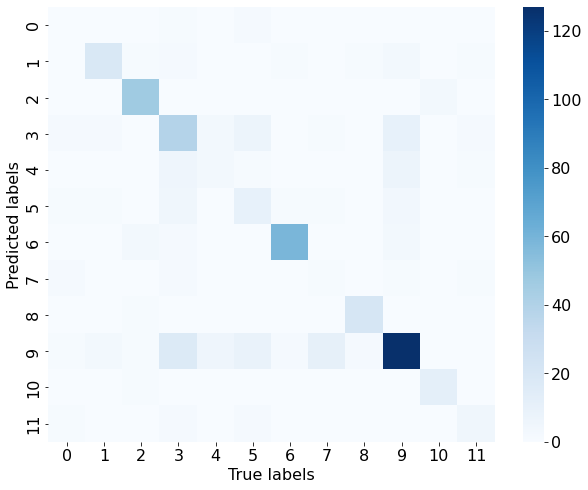

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):' ,f1_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

